# **Projet Python 2A**

**Tony Lauze - Fanny Daubet**

*Ce projet est réalisé dans le cadre du cours de Python de Lino Galiana pour l'année 2023-2024.*


## **Introduction**

Le but de ce projet est de **modéliser le prix de l'immobilier en région parisienne** et, plus précisément, des appartements dans Paris intra-muros.

La base de donnée principale qui sera utilisée, est le **fichier Demandes de Valeurs Foncières (DVF)**, produit par la direction générale des finances publiques, qui recense les transactions immobilières intervenues au cours des cinq dernières années en France, à partir des actes notariés.

Comme toutes les ventes de ce fichier sont géolocalisées, l'enrichissement principal qui sera apporté à la base de données sera l'ajout, pour chaque appartement, de la **distance minimale à certains lieux d'intérêt parisiens** (stations de métro, espaces verts, lieux historiques, etc.).

Pour la modélisation, on procédera d'abord à une approche "économétrique" utilisant des régressions simples et des régressions de panel avec effets fixes, puis on abordera le problème d'un point de vue plus orienté prédiction et "machine learning", avec des régressions LASSON, RIDGE, et une méthode RandomForest. 

Les grandes étapes sont donc les suivantes :
- Etape 1 : Prise en main et nettoyage du fichier DVF, création d'une base de données de départ
- Etape 2 : Visualisation spatiale et temporelle
- Etape 3 : Enrichissement des données, en récupérant en open data et scrapping les localisations de plusieurs catégories de lieux d'intérêt parisiens
- Etape 4 : Modélisation, approche économétrique et machine learning

## **I) Nettoyage des données**

### **1) Nettoyage**

Les fichiers DVF bruts pour le département 75 (Paris intra-muros) peuvent être trouvés dans le dossier `0) Données_brutes`. Les principales variables renseignées dans ce fichier sont :

- `id_mutation` : Identifiant de mutation (non stable, sert à grouper les lignes)
- `date_mutation` : Date de la mutation au format ISO-8601 (YYYY-MM-DD)
- `valeur_fonciere` : Valeur foncière (séparateur décimal = point)
- `lot_1_numero` : Numéro du lot 1, qui nous servira pour le nettoyage
- `lot_1_surface_carrez` : Surface Carrez du lot 1
- `type_local` : Libellé du type de local (appartement, local commercial, maison, dépendance)
- `surface_reelle_bati` : Surface réelle du bâti
- `nombre_pieces_principales` : Nombre de pièces principales
- `longitude` : Longitude du centre de la parcelle concernée (WGS-84)
- `latitude` : Latitude du centre de la parcelle concernée (WGS-84)

Le code utilisé pour nettoyer les fichiers étant fastidieux, et l'exécution assez longue, cette étape sera seulement résumée ici, et quelques fonctions principales exhibées, mais le code complet peut être consulté dans le dossier `1.0) Nettoyage` dans le notebook `Nettoyage.ipynd`.

Le but du nettoyage était le suivant :

D'abord, se restreindre aux ventes d'appartement, afin d'isoler un marché plus homogène que l'immobilier en général. Pour ce faire, il s'agissait de retirer les ventes de maisons et de locaux commerciaux, en prenant garde aux ventes groupées qui pouvaient survenir (par exemple, une vente d'un appartement et d'un local commercial) : il fallait donc retier, dans ce cas, toutes les lignes corresponant à l'identifiant de vente problématique. 

La fonction suivante permet ce traitement :

In [1]:
def retirer_maison_locaux(df):
    
    #on regroupe les identifiants de vente en comptant le nombre de maisons et de locaux
    ventes_group = df.groupby('id_mutation').agg({'maison_ind': 'sum', 'local_ind': 'sum'})
    
    #on localise les identifiants des ventes où il y a une maison ou un local
    ventes_a_supp = ventes_group.loc[(ventes_group['maison_ind']>0) | (ventes_group['local_ind']>0)] 

    #on convertit en dataframe
    ventes_a_supp = pd.DataFrame(ventes_a_supp) 

    #on créée la liste des ventes à supprimer en récupérant l'index
    list_ventes_a_supp = ventes_a_supp.index.tolist() 

    #on retire les ventes 
    df = df.set_index('id_mutation') #on passe l'id_de vente en index
    df = df.drop(list_ventes_a_supp) #on drop tous les id présents dans la liste à supprimer

    #on repasse l'identifiant de mutation en colonne et on reset l'index
    df = df.reset_index()

    return df

Ensuite, il s'agissait d'ajouter aux appartement le nombre de leurs dépendances (balcons, cave, garage, etc.). Ici, un traitement différencié selon les années était nécessaire.

Pour les fichiers 2022 et 2023, la variable `lot1_numero` permet, quand il y a une vente contenant par exemple 2 appartements et 5 dépendances, de retrouver quelles dépendances sont associées à chacun des appartements, en les associant selon leur numéro de lot. 

Mais pour les fichiers d'avant 2022, la variable 'lot11_numero' ne permet plus ce traitement. Il fallait alors se restreindre aux ventes qui contenaient un seul appartement, et lui associer toutes les éventuelles dépendances contenues dans la vente.

Egalement, pour les ventes groupées qui contiennnet plus d'un appartement, il n'y a pour ces appartements qu'un seul prix renseigné dans la colonne `valeur_fonciere`. On associe donc à chaque appartement son prix individuel, en faisant un prorata selon la surface renseignée dans la colonne `surface_reelle_bati`.

La fonction suivante permet ce traitement, pour le cas des années 2022 et 2023 :

In [2]:
def nettoyage_vente_2022_2023(id, df):
    #id : indice de la vente
    #df : dataframe
    
    mini_df = df.loc[(df['id_mutation']==id)] #on récupère la vente
    mini_df_appart = df.loc[(df['id_mutation']==id) & (df['appartement_ind']==1)] #on récupère les appartements de cette vente
    index_app = mini_df_appart.index.tolist() #index des appartements
    
    nb_tot_app = mini_df_appart['appartement_ind'].sum() #nombre total d'appartments dans la vente
    
    if nb_tot_app > 1: #s'il y a au moins un appartement dans la vente, on essaie de récupérer pur chaque appart. la surface du lot associé
        
        mini_df_group_lot_dep = mini_df.groupby('lot1_numero').sum()['dependance_ind'] #pour chaque numéro de lot, on récupère le nombre de dépendance

        #pour chaque appartement dans la vente, on met à jour les informations du nombre de dépendance
        for index in index_app:
            num_lot = mini_df.loc[index,'lot1_numero'] #on récupère le numéro de lot associé à l'appartement
            nb_dépendance = mini_df_group_lot_dep[num_lot] #on récupère le nombre de dépendances
            df.loc[index,'nombre_dependances']=nb_dépendance #on met à jour le dataframe

        #enfin, on met à jour le prix
        
        if nb_tot_app > 1: #s'il y a plus d'un appartement dans la vente, on met à jour le prix au prorata de la surface réelle
            surface_totale = mini_df_appart['surface_reelle_bati'].sum() #surface réelle totale
            prix_lot = mini_df_appart.loc[index_app[0]]['valeur_fonciere'] #on récupère la valeur foncière totale
            
            for index in index_app: #pour chaque appartement, on fait le prorata selon sa surface réelle
                surface_app = mini_df_appart.loc[index]['surface_reelle_bati'] #on récupère la surface de l'appartement
                df.loc[index, 'prix'] = prix_lot*(surface_app)/(surface_totale) #on met à jour le prix
                
        else: #si un seul appartement, rien à faire
            pass
            
    elif nb_tot_app == 1: #s'il y a un seul appartement dans la vente, on lui ajoute toutes les dépendances de la vente
        
        nb_dep = mini_df['dependance_ind'].sum()
        
        df.loc[index_app[0],'nombre_dependances']=nb_dep #on met à jour le dataframe
            
    else: #si aucun appartement dans la vente, rien à faire
        pass

On pouvait également ajouter, pour les appartements où elle était renseignée dans la colonne `lot_1_surface_carrez`, la surface en loi carrez. Puis, calculer le prix au m^2, soit selon la surface réelle du bâti, soit selon la surface en loi carrez. 

Enfin, on se restreint aux appartements pour lesquels on a bien une surface, une localisation, un prix.

Toutes ces étapes, ainsi que l'élimination des variables inutiles et le renommage de certaines, sont effectuées par les fonctions :

- `nettoyage_2022_2023` pour les fichiers DVF de 2022 et 2023
- `nettoyer_avant_2022` pour les fichiers DVF antérieurs

Les données nettoyées sont exportées (en .csv) dans le dossier `1.1) Données clean`.

### **2) Concaténation des années**

On concatène ensuite les fichiers DVF des différentes années, et on en profite pour retirer les valeurs extrêmes pour les variables numériques d'intérêt (prix, surface, prix au m^2), et pour convertir le fichier en Geodataframe. Cela est effectué dans le notebook `Concaténer.ipynb` du dossier `1.2) Données concat`.

Le passage en Geodataframe permet également d'ajouter le quartier parisien auquel appartient l'appartement, grâce à la fonction `sjoin` de la bibliothèque Geopandas et aux données administratives des arrondissements et des quartiers parisiens, qui se trouvent ici : `Projet-python-2A/2) Visualisation/Données_carto`

Au final, on obtient donc dans le dossier `1.2) Données concat` un fichier `dvf_concat_total.geojson` qui sera notre base de travail, notamment pour la visualisation.

## **II) Visualisation**

Le but de cette partie est de visualiser (spatialement et temporellement) les données du fichier DVF, pour vérifier qu'elles sont bien conformes à l'intuition et pour engranger déjà quelques idées en vue de la modélisation.

Les codes des fonctions utilisées dans cette partie sont dans le fichier `Visualisation.py`, on n'en montrera qu'une par partie.

### **1) Evolution temporelle**

Dans un premier temps, on va observer l'évolution temporelle du prix de l'immobilier, et du nombre de ventes, en région parisienne.

In [234]:
"""Librairies nécessaires"""
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
from shapely.geometry import Point 

"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-python-2A')

"""Récupération des données DVF"""
path_dvf = '1.2) Données concat/dvf_concat_total.geojson'
dvf = gpd.read_file(path_dvf)

In [221]:
"""Première lignes du fichier DVF"""
dvf.head(3)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,adresse_numero,adresse_nom_voie,code_postal,code_commune,nom_arrondissement,num_arrondissement,nom_quartier,longitude,latitude,geometry
60225,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,4.0,RUE DE LA BIENFAISANCE,75008,75108,Paris 8e Arrondissement,08,Europe,2.320982,48.876954,POINT (2.32098 48.87695)
60226,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,313.0,RUE DES TOURNELLES,75003,75103,Paris 3e Arrondissement,03,Archives,2.367136,48.856147,POINT (2.36714 48.85615)
60227,2021-1680094,2021-01-06,1000000.0,13.815511,2.0,60.0,66.13,1.0,15122.0,16667.0,16.0,RUE DU PARC ROYAL,75003,75103,Paris 3e Arrondissement,03,Archives,2.362974,48.859331,POINT (2.36297 48.85933)


In [3]:
"""Evolution du prix moyen des appartements vendus, à une fréquence mensuelle"""

def evolution_prix_mensuel(dvf):
    #dvf : dataframe avec une colonne date_mutation et prix

    #ne garder que les colonnes utiles
    dvf = dvf.loc[:,['prix', 'date_mutation']]
    
    # Création d'une colonne au format datetime
    dvf['date_time'] = pd.to_datetime(dvf['date_mutation'])
    
    # Conversion de la colonne 'date_time' en format de période mensuelle
    dvf['mois'] = dvf['date_time'].dt.to_period('M')
    
    # Grouper par mois et calculer la moyenne des prix
    dvf_grouped = dvf.groupby('mois')['prix'].mean().reset_index()
    
    # Tracer l'évolution mensuelle des prix
    plt.figure(figsize=(8, 5))
    plt.plot(dvf_grouped['mois'].astype(str), dvf_grouped['prix'], marker='o', linestyle='-', color='b')
    
    # Diminuer la fréquence des étiquettes sur l'axe des x
    n = len(dvf_grouped['mois'])
    step = max(1, n // 10)  # Vous pouvez ajuster le pas selon vos besoins
    plt.xticks(dvf_grouped.index[::step], dvf_grouped['mois'].iloc[::step], rotation=45, ha='right')
    
    # Ajouter des étiquettes et un titre
    plt.xlabel('Mois')
    plt.ylabel('Prix moyen')
    plt.title('Évolution Mensuelle du prix moyen des appartements vendus à Paris depuis 2018')
    
    # Afficher la grille
    plt.grid(True)

    # Enregistrer la figure dans le dossier spécifié
    output_folder = '2) Visualisation/Sorties_graph'
    output_filename = 'evolution_mensuelle_prix.png'
    output_path = os.path.join(output_folder, output_filename)
    
    # Enregistrer la figure
    plt.savefig(output_path)
    
    # Afficher le graphique
    plt.show()

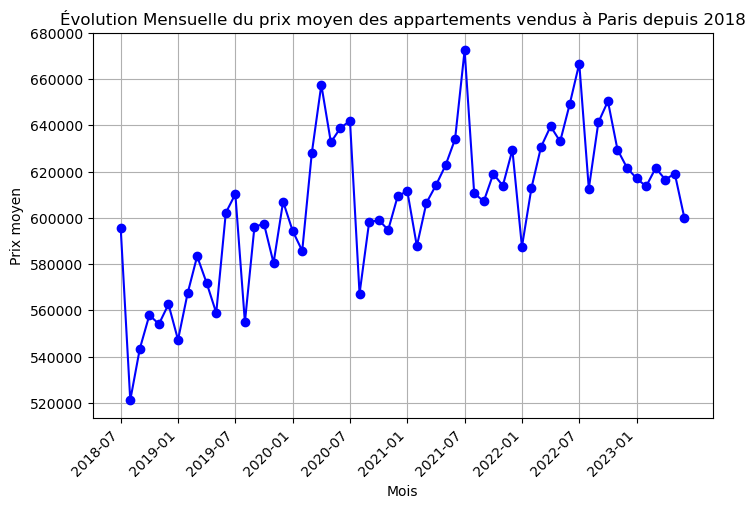

In [4]:
"""Application de la fonction"""
evolution_prix_mensuel(dvf)

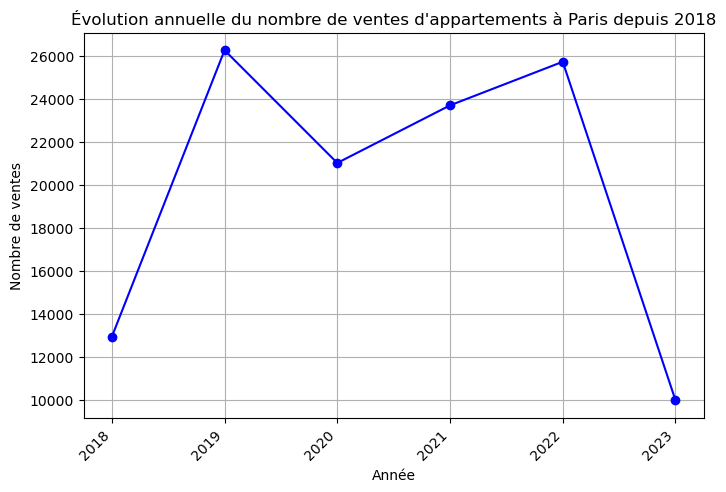

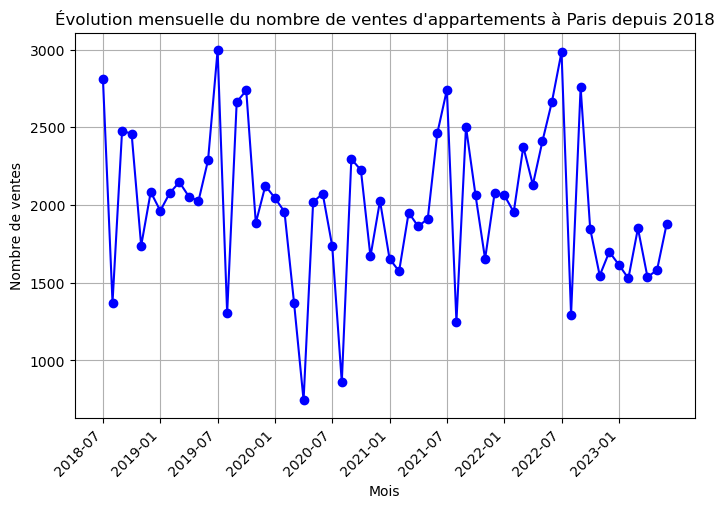

In [5]:
"""Evolution du nombre d'appartements vendus, à une fréquence annuelle ou mensuelle"""

from Visualisation import evolution_nombre

evolution_nombre(dvf, "Année")
evolution_nombre(dvf, "Mois")

**Remarques :**

Ces évolutions temporelles permettent de mettre en évidence plusieurs choses.

- D'abord, il y a une augmentation du prix moyen de l'immobilier en région parisienne ces dernières années. Cela justifie que nous nous restreigons aux ventes qui ont eu lieu entre 2021 et 2023, afin de se placer sur une période où le prix semble assez homogène.

- Il y a moins de ventes pour les années 2018 et 2023, mais cela vient du fait que ces fichiers sont tronqués (l'année 2023 ne contient que le premier trimestre, et 2018 que le dernier).

- Il semble y avoir une dimension cyclique dans le prix et dans le nombre des ventes. Ainsi, il y a toujours beaucoup moins de ventes durant le mois d'août, mais un pic au printemps (pour le nombre et le prix). Cela justifierait l'ajout d'une dimension temporelle dans notre modélisation.

- On peut remarquer l'effet de la crise sanitaire : il y a eu une chute du nombre de ventes pour les mois de mars et d'avril 2020.

On se restreint donc à la période 2021-2023 à partir de maintenant.

In [98]:
"""Restriction à la période 2021-2023"""
dvf = dvf.loc[(dvf['date_mutation'].dt.year >= 2021) & (dvf['date_mutation'].dt.year <= 2023)]

### **2) Visualisation graphique**

Ici, on représente le prix moyen (brut, et au m^2) des appartements vendus, selon l'arrondissement et le quartier parisien. Il s'agit de mettre en évidence que certains quartiers sont plus chers que d'autres, ce qui justifiera d'incorporer le quartier dans la modélisation.

In [99]:
"""Données administratives géographiques de paris intra muros"""

paris_arrondissement = gpd.read_file('2) Visualisation/Données_carto/paris_arrondissements.geojson')
paris_quartiers = gpd.read_file('2) Visualisation/Données_carto/paris_quartiers.geojson')
paris_quartiers = paris_quartiers[['c_quinsee', 'l_qu', 'geometry']]

In [100]:
"""Fonction qui trace le prix moyen du m^2 par arrondissement"""

def carte_prix_moyen_arrodissement(dvf):
    #dvf : geodataframe avec une colonne 'geometry'

    #on ne garde que les colonnes prix au m^2 et geometry
    dvf = dvf[['prix_au_m2_carrez', 'prix_au_m2_reel_bati', 'geometry']]  

    #on ajoute à chaque appartement les données administratives de son arrondissement
    dvf_geo = gpd.sjoin(dvf, paris_arrondissement, predicate = 'within')

    #regroupement selon les arrondissements et prix moyen au m2 carrez
    dvf_geo_group_carrez = (dvf_geo
      .groupby("INSEE_COG")
      .agg({"prix_au_m2_carrez": "mean"})
      .reset_index())

    #regroupement selon les arrondissements et prix moyen au m2 réel
    dvf_geo_group_reel = (dvf_geo
      .groupby("INSEE_COG")
      .agg({"prix_au_m2_reel_bati": "mean"})
      .reset_index())

    #on ajoute aux données administratives les prix moyens
    paris_arrondissement_count_carrez = paris_arrondissement.merge(
        dvf_geo_group_carrez
    ).to_crs(2154)

    paris_arrondissement_count_reel = paris_arrondissement.merge(
        dvf_geo_group_reel
    ).to_crs(2154)

    # Créer une figure avec deux sous-graphiques côte à côte
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Première carte (à gauche)
    paris_arrondissement_count_carrez.plot(ax=ax1, column="prix_au_m2_carrez", cmap="coolwarm", legend=True)
    ax1.set_title('Prix moyen du m^2 carrez - Carte 1')
    ax1.set_xticks([], [])
    ax1.set_yticks([], [])
    
    # Deuxième carte (à droite)
    paris_arrondissement_count_reel.plot(ax=ax2, column="prix_au_m2_reel_bati", cmap="coolwarm", legend=True)
    ax2.set_title('Prix moyen du m^2 reel bati - Carte 2')
    ax2.set_xticks([], [])
    ax2.set_yticks([], [])
    
    # Ajuster l'espacement entre les sous-graphiques
    plt.subplots_adjust(wspace=0.2)

    # Chemin de sortie
    output_folder = '2) Visualisation/Sorties_graph'
    output_filename = 'prix_moyen_arrondissements.png'
    output_path = os.path.join(output_folder, output_filename)
    
    # Enregistrer la figure
    plt.savefig(output_path)

    plt.show()

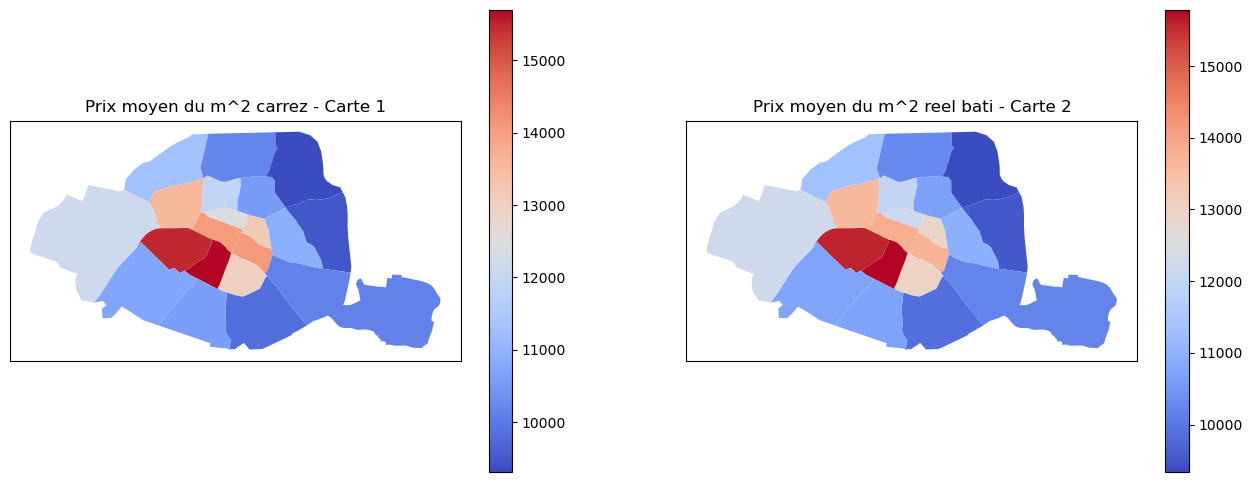

In [101]:
"""Application de la fonction"""

carte_prix_moyen_arrodissement(dvf)

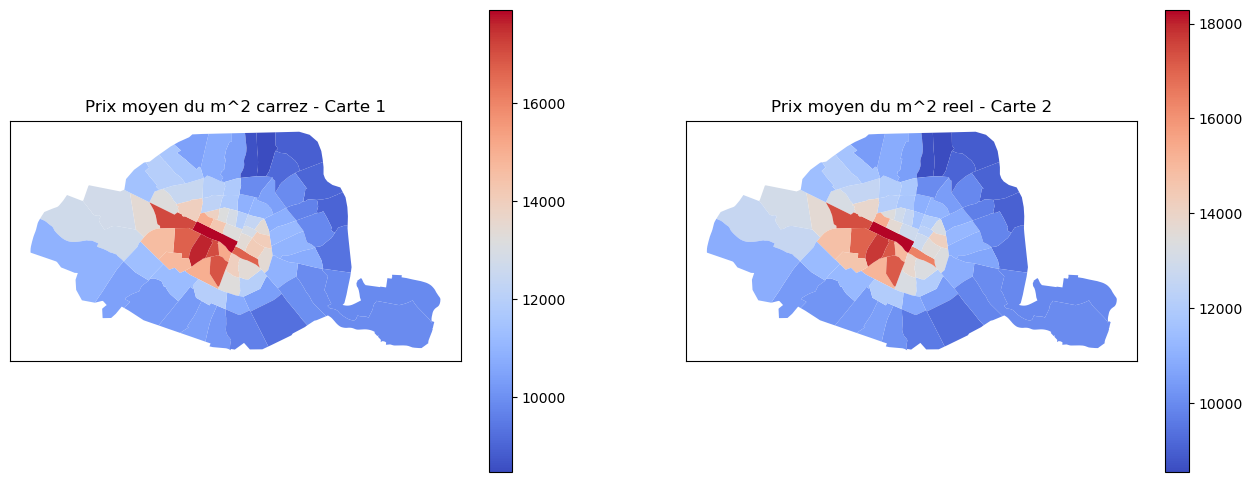

In [102]:
"""Carte du prix moyen par quartier"""

from Visualisation import carte_prix_moyen_quartier

carte_prix_moyen_quartier(dvf)

**Remarques :**

Ces cartes permettent de mettre en évidence un effet quartier sur le prix des appartements. Les quartiers les plus chers se trouvent au centre de Paris. En particulier, le quartier de Saint-Germain des Prés, dans le 6ème arrondissement, et les quartiers de l'Ile Saint-Louis et de Notre-Dame, sont parmi les plus chers. Les quartiers en bordure de Paris (notamment le 19ème et le 20ème) sont moins chers, à part le 16ème arrondissement.

## **III) Enrichissement des données**

Le but de cette partie est d'enrichir la base de données DVF avec des informations susceptibles d'influencer le prix de l'immobilier. Comme il faut que l'information varie d'un appartement à un autre, une manière naturelle de procéder est d'ajouter la distance minimale des appartements à plusieurs catégories de lieu d'intérêt.

Toutes les données utilisées ici sont disponible en open data, mais ont été enregistrées dans le dossier `3.0) Enrichissement données/Données` au format Geojson pour plus de facilité. Les sources exactes sont précisées au début de chaque partie.

Pour les lieux d'intérêt, nous retenons ici : 

- Les espaces verts parisiens, en opérant une distinction entre les grands espaces verts (Jardin des Plantes, Jardin des Tuileries, etc.) et les squares.
- Les meilleurs lycées, dont la liste des 100 premiers est récupérée par scrapping sur le site du Figaro.
- Les transports (stations de métro et de RER)
- Les sites historiques (musées, monuments, églises)
- Les voies d'eau (en particulier la Seine)

Les codes des fonctions utilisées dans cette partie sont dans le fichier `Enrichissement.py`, on ne montrera la fonction qui calcule les distances minimales que pour le premier type de lieu d'intérêt, à savoir les parcs. La méthode est en effet toujours la même :

- Récupérer les données en open-data
- Affiner selon des critères spécifiques
- Utiliser la fonction `sjoin_nearest` de la biliothèque GeoPanda, qui compare les colonnes `geometry` de deux dataframes pour trouver automatiquement, dans notre cas, le lieu d'intérêt le plus proche pour chaque appartement, et qui calcule la distance minimale

### **1) Ajout des espaces verts**

Le but est de trouver l'espace vert le plus proche de chaque appartement, en différenciant selon le type d'espace vert.

*Source des données sur les espaces verts : https://opendata.paris.fr/explore/dataset/espaces_verts/information*

In [103]:
"""Lecture du fichier des parcs"""
emplacement_parcs = '3.0) Enrichissement données/Données/Espaces_verts_parisiens.geojson'
df_espaces_verts_brut = gpd.read_file(emplacement_parcs, low_memory=False, index_col=0)
df_espaces_verts_brut.head(2)

,nsq_espace_vert,nom_ev,type_ev,categorie,adresse_numero,adresse_complement,adresse_typevoie,adresse_libellevoie,adresse_codepostal,poly_area,...,id_division,id_atelier_horticole,ida3d_enb,site_villes,id_eqpt,competence,geom,url_plan,geom_x_y,geometry
0,10383.0,JARDINIERE DE LA RUE DUMERIL,Décorations sur la voie publique,Jardiniere,1.0,NaN,RUE,DUMERIL,75013,4.0,...,113.0,19.0,JDE7336,SV,7336,CA,NaN,http://p70-planet.apps.paris.mdp/Advitium/Appe...,NaN,"POLYGON ((2.35752 48.83770, 2.35752 48.83769, ..."
1,363.0,SQUARE JEAN COCTEAU,Promenades ouvertes,Square,122.0,NaN,AVENUE,FELIX FAURE,75015,3295.0,...,115.0,29.0,57896,1318,3619,CA,NaN,http://p70-planet.apps.paris.mdp/Advitium/Appe...,NaN,"POLYGON ((2.28064 48.83851, 2.28075 48.83842, ..."


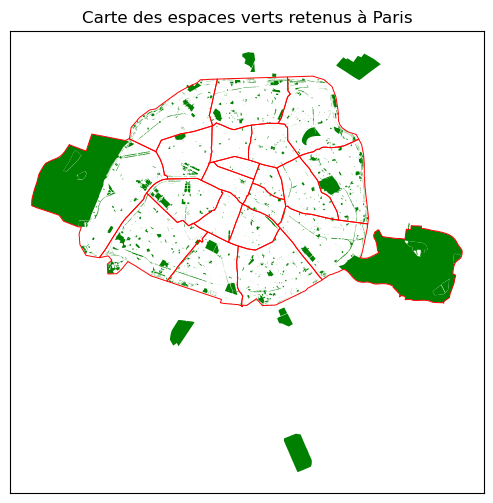

In [104]:
"""Visualisation des espaces verts sur une carte"""

fig, ax = plt.subplots(figsize=(8, 6))

base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "red", linewidth = 0.7)
df_espaces_verts_brut.plot(ax=ax, color='green')

plt.xticks([], [])
plt.yticks([], [])

plt.title('Carte des espaces verts retenus à Paris')

plt.show()

On voit qu'il y a plusieurs modifications à faire.

D'abord, il manque le Jardin des plantes, le Jardin des tuileries, et du Luxembourg. Cela provient du fait que le fichier de départ est celui de la voirie de Paris (qui ne s'occupe pas du Jardin du Luxebourg par exemple, car il dépend du Sénat). On va donc les rajouter manuellement, selon les coordonnées qu'on peut voir ci-dessous.

In [105]:
coord_jardin_du_luxembourg = [
    [48.848583, 2.332634],
    [48.849056, 2.338542],
    [48.847234, 2.340275],
    [48.844127, 2.338816],
    [48.844720, 2.332550]
]

coord_jardin_des_plantes = [
    [48.846779, 2.360882],
    [48.843693, 2.364841],
    [48.841292, 2.356097],
    [48.843813, 2.355056]
]

coord_jardin_des_tuileries = [
    [48.866346, 2.323663],
    [48.863713, 2.331903],
    [48.861017, 2.329972],
    [48.863854, 2.321604]
]

In [213]:
"""Ajout des 3 parcs manquants"""

from Enrichissement import ajout_3_parcs

df_espaces_verts_brut = ajout_3_parcs()

df_espaces_verts_brut.tail(3)

,nsq_espace_vert,nom_ev,type_ev,categorie,adresse_numero,adresse_complement,adresse_typevoie,adresse_libellevoie,adresse_codepostal,poly_area,...,id_division,id_atelier_horticole,ida3d_enb,site_villes,id_eqpt,competence,geom,url_plan,geom_x_y,geometry
2286,NaN,JARDIN DES PLANTES,NaN,Parc,NaN,NaN,NaN,NaN,75,221416.238529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((2.36088 48.84678, 2.36484 48.84369, ..."
2287,NaN,JARDIN DES TUILERIES,NaN,Parc,NaN,NaN,NaN,NaN,75,220233.048327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((2.32366 48.86635, 2.33190 48.86371, ..."
2288,NaN,JARDIN DU LUXEMBOURG,NaN,Parc,NaN,NaN,NaN,NaN,75,251125.065297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((2.33263 48.84858, 2.33854 48.84906, ..."


On distingue ensuite les grands parcs et les squares, en créant deux sous-dataframe `df_grands_parcs` et `df_squares`. Pour les parcs, comme pour les squares, on choisit une aire minimale afin de ne garder que les plus importants. On les représente ensuite sur une carte de Paris

In [107]:
"""On créée un premier dataframe df_grands_parcs"""

#on garde les espaces verts de plus de X m^2
df_grands_parcs = df_espaces_verts_brut.loc[df_espaces_verts_brut['poly_area']>50000]

#on ne garde que les parcs parisiens
df_grands_parcs = df_grands_parcs[df_grands_parcs['adresse_codepostal'].astype(str).str.startswith('75')]

#on gardes les types d'intérêt
df_grands_parcs = df_grands_parcs.loc[df_grands_parcs['categorie'].isin(['Jardin', 'Parc', 'Cimetière', 'Bois', 'Esplanade'])]

df_grands_parcs.shape

(31, 30)

In [108]:
"""On créée un dataframe df_squares contenant les squares"""

#on garde les squares
df_squares = df_espaces_verts_brut.loc[df_espaces_verts_brut['categorie'].isin(['Square'])].copy()

#on les réduit à leur centre
proj_lambert = 'EPSG:3942'
df_squares = df_squares.to_crs(proj_lambert)
df_squares['geometry'] = df_squares['geometry'].centroid
proj_wgs84 = 'EPSG:4326'
df_squares = df_squares.to_crs(proj_wgs84)

#on garde les X plus grands
df_squares = df_squares.nlargest(50, 'poly_area')

df_squares.shape

(50, 30)

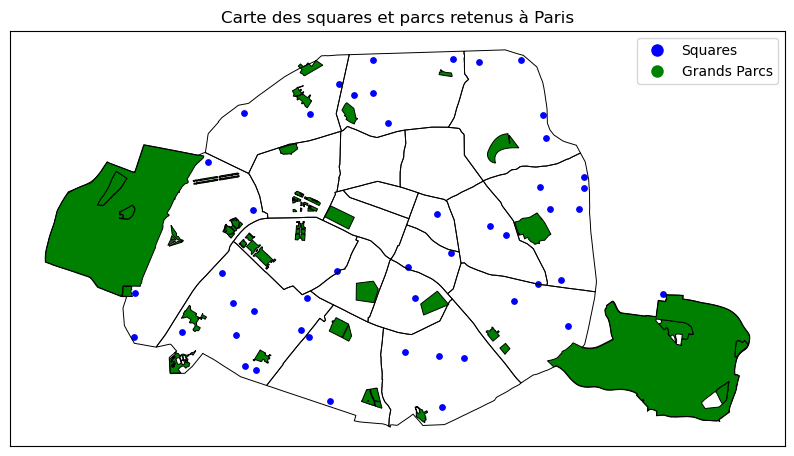

In [109]:
"""Visualisation des squares et des parcs sur une carte"""
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 8))

base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
df_squares.plot(ax=ax, color='blue', markersize=15, label='Squares')
df_grands_parcs.plot(ax=ax, color='green', alpha=1, edgecolor='black', linewidth=0.7, label='Grands parcs')

plt.xticks([], [])
plt.yticks([], [])

# Créez des objets de légende explicites
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Squares'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Grands Parcs')
]

# Ajoutez une légende en utilisant les objets de légende explicites
ax.legend(handles=legend_elements)

plt.title('Carte des squares et parcs retenus à Paris')
plt.savefig('3.0) Enrichissement données/Sorties_cartes/carte_parcs_squares.png')

plt.show()

Maintenant, on définit les deux fonctions qui vont ajouter, pour chaque appartement du dataframe `dvf` le nom de l'espace vert (parc ou square) retenu le plus proche, et ainsi que la distance minimale (à vol d'oiseau).

In [110]:
"""Fonction qui merge les data set en trouvant le parc (polygone) le plus proche et enregistre la distance (en km)"""

def ajout_grands_parc(dvf, df_grands_parcs):

    #sélection des variables
    var_parcs = ['nom_ev', 'geometry']
    df_grands_parcs = df_grands_parcs[var_parcs].copy()
    
    #Passer en projection 2D
    proj_lambert = 'EPSG:3942'
    dvf = dvf.to_crs(proj_lambert)
    df_grands_parcs = df_grands_parcs.to_crs(proj_lambert)

    #jointure spatiale
    merged_nearest = gpd.sjoin_nearest(dvf, df_grands_parcs, how="left", max_distance=5000, distance_col="dist_min_grand_parc")

    #dist en km
    merged_nearest['dist_min_grand_parc'] = merged_nearest['dist_min_grand_parc']/1000

    #repasser en système de projection wgs 84
    dvf_avec_parc = merged_nearest.to_crs('EPSG:4326')

    #supprimer et renommer colonnes
    dvf_avec_parc = dvf_avec_parc.drop(['index_right'], axis=1)    
    dvf_avec_parc = dvf_avec_parc.rename(columns={'nom_ev': 'nom_grand_parc'})

    return dvf_avec_parc

In [111]:
"""Fonction qui merge les data set en trouvant le square (point) le plus proche et enregistre la distance (en km)"""

def ajout_squares(dvf, df_squares):
    
    #sélection des variables
    var_squares = ['nom_ev', 'geometry']
    df_squares = df_squares[var_squares].copy()
    
    #Passer en projection 2D
    proj_lambert = 'EPSG:3942'
    dvf = dvf.to_crs(proj_lambert)
    df_squares = df_squares.to_crs(proj_lambert)

    #jointure spatiale
    merged_nearest = gpd.sjoin_nearest(dvf, df_squares, how="left", max_distance=5000, distance_col="dist_min_square")

    #dist en km
    merged_nearest['dist_min_square'] = merged_nearest['dist_min_square']/1000

    #repasser en système de projection wgs 84
    dvf_avec_squares = merged_nearest.to_crs('EPSG:4326')

    #supprimer et renommer colonnes
    dvf_avec_squares = dvf_avec_squares.drop(['index_right'], axis=1)    
    dvf_avec_squares = dvf_avec_squares.rename(columns={'nom_ev': 'nom_square'})

    return dvf_avec_squares

In [112]:
"""Application des fonctions"""

dvf_avec_parcs = ajout_grands_parc(dvf, df_grands_parcs)

dvf_avec_ev = ajout_squares(dvf_avec_parcs, df_squares)

In [113]:
dvf_avec_ev.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,nom_arrondissement,num_arrondissement,nom_quartier,longitude,latitude,geometry,nom_grand_parc,dist_min_grand_parc,nom_square,dist_min_square
60225,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,Paris 8e Arrondissement,08,Europe,2.320982,48.876954,POINT (2.32098 48.87695),PARC MONCEAU,0.715347,SQUARE DES BATIGNOLLES,1.228584
60226,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,Paris 3e Arrondissement,03,Archives,2.367136,48.856147,POINT (2.36714 48.85615),JARDIN DES PLANTES,1.146792,SQUARE LOUIS XIII,0.131711


### **2) Ajout des transports**

Ici on ajoute les transports, en suivant la même procédure que pour les parcs. Commençons par charger les données, effectuer quelques modifications pour conserver seulement les stations de métro, de RER et de Tram, puis visualiser les stations retenues.

*Source des données de transport : https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf/information/*

In [115]:
"""Lecture du fichier transports"""

emplacement = '3.0) Enrichissement données/Données/Transports_idf.geojson'
df_transport = gpd.read_file(emplacement, low_memory=False, index_col=0)
df_transport.head(2)

,geo_point_2d,id_gares,nom_gares,nom_so_gar,nom_su_gar,id_ref_zdc,nom_zdc,id_ref_zda,nom_zda,idrefliga,...,tertram,terval,exploitant,idf,principal,x,y,picto,nom_iv,geometry
0,"{'lon': 2.372103138402568, 'lat': 48.963755428...",643,Pierrefitte Stains,NaN,NaN,72787,Pierrefitte - Stains,43179,Pierrefitte - Stains,A01842,...,0,0,SNCF,1,0,654024.0938,6.873939e+06,"{'thumbnail': True, 'filename': 'RER_D.svg', '...",Pierrefitte Stains,POINT (2.37210 48.96376)
1,"{'lon': 2.312307716888593, 'lat': 48.780313795...",102,Bourg-la-Reine,NaN,NaN,70033,Bourg-la-Reine,43097,Bourg-la-Reine,A01857,...,0,0,RATP,1,0,649468.2085,6.853578e+06,"{'thumbnail': True, 'filename': 'RER_B.svg', '...",Bourg-la-Reine,POINT (2.31231 48.78031)


In [116]:
"""Modifications du fichier"""

var_interet = ['nom_gares', 'nom_so_gar', 'nom_su_gar', 'idrefligc', 'res_com', 'indice_lig', 'mode', 'tertrain', 'terrer',
       'termetro', 'tertram', 'terval', 'exploitant', 'idf', 'geometry']

df_transport = df_transport.loc[:, var_interet]

#création de sous dataframes selon le type de transport
df_metro = df_transport.loc[df_transport['mode']=='METRO']
df_rer = df_transport.loc[df_transport['mode']=='RER']
df_tram = df_transport.loc[df_transport['mode']=='TRAMWAY']

#réduction du df
df_transport = df_transport.loc[df_transport['mode'].isin(['METRO', 'RER', 'TRAMWAY'])]

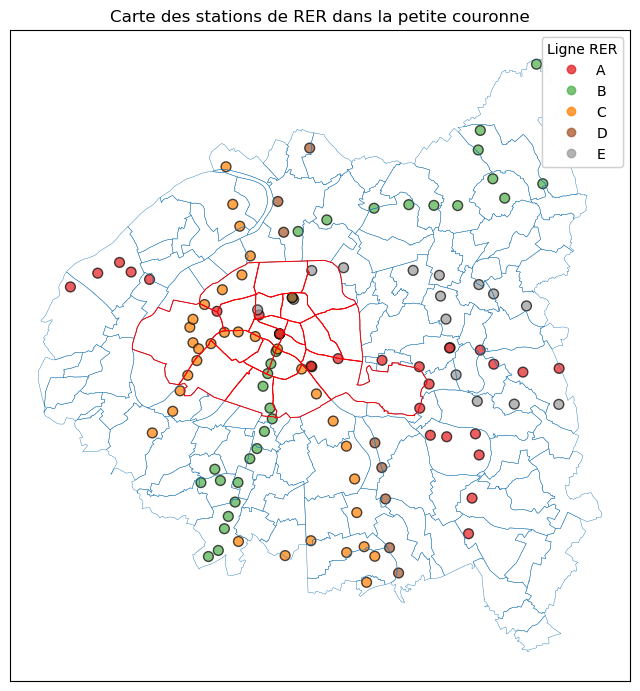

In [117]:
"""Visualisation des stations RER"""

from Enrichissement import plot_rer_stations

plot_rer_stations()

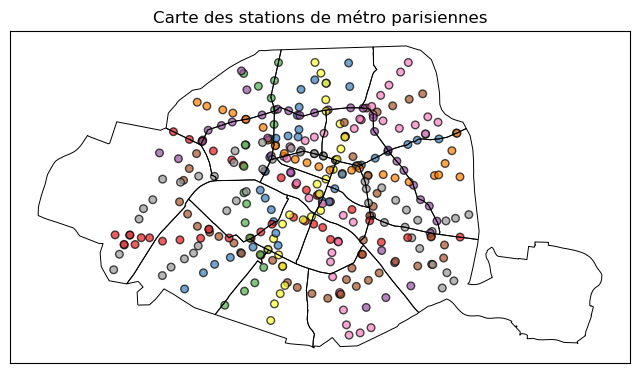

In [118]:
"""Visualisation des stations de métro"""

from Enrichissement import carte_metro

carte_metro()

Maintenant, on ajoute la station de transport la plus proche (ainsi que son nom, le numéro de la ligne, et la distance minimale), au fichier dvf.

In [119]:
from Enrichissement import ajout_stat_trans

dvf_avec_trans = ajout_stat_trans(dvf_avec_ev, df_transport)

In [120]:
dvf_avec_trans.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,longitude,latitude,geometry,nom_grand_parc,dist_min_grand_parc,nom_square,dist_min_square,nom_stat,num_ligne,dist_min_stat
60225,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,2.320982,48.876954,POINT (2.32098 48.87695),PARC MONCEAU,0.715347,SQUARE DES BATIGNOLLES,1.228584,Europe,3,0.224501
60226,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,2.367136,48.856147,POINT (2.36714 48.85615),JARDIN DES PLANTES,1.146792,SQUARE LOUIS XIII,0.131711,Chemin Vert,8,0.132209


### **3) Ajout des lycées**

Ici on ajoute la distance minimale aux meilleurs lycées parisiens. La liste des meilleurs lycées est obtenue par scrapping sur le classement du figaro, et elle a été enregistrée ici : `3.0) Enrichissement données/Données/liste_meilleurs_lycées.pkl` au cas où la structure du site changerait. Le code du scrapping est présenté ci-dessous (afficher la liste si nécessaire).

*Source des données des lycées : https://data.iledefrance.fr/explore/dataset/lycees-donnees-generales/export/*

In [124]:
import requests
from bs4 import BeautifulSoup

!pip install unidecode
from unidecode import unidecode

!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

import pickle

# URL du classement des lycées à Paris
url = 'https://classement-lycees.etudiant.lefigaro.fr/ville-paris+75056/'

# Récupérer le contenu HTML de la page
response = requests.get(url)
html_content = response.content

# Utiliser BeautifulSoup pour parser le HTML
soup = BeautifulSoup(html_content, 'html.parser')

# Trouver les noms des lycées dans le classement
lycees_classement = [lycee.find('b').text.strip() for lycee in soup.find_all('td', class_='school')]

# Passer tous les noms en majuscule, retirer la partie 'LYCEE ' des noms
lycees_liste = [unidecode(lycee.replace('Lycée ', '').replace('LYCEE ', '').replace('-', '').replace(' ', '').upper()) for lycee in lycees_classement]

#changer l'écriture de Henri IV
for i in range(len(lycees_liste)):
    lycees_liste[i] = lycees_liste[i].replace('HENRI-IV', 'HENRI IV')

#afficher la liste
#lycees_liste

On charge ensuite la liste des lycées parisiens, puis on utilise la fonction `has_similar_name` ci-dessous pour comparer la similitude de chaînes de caractères, afin de ne garder que les lycées qui sont dans la liste des meilleurs lcyées retenus. Enfin, on visualise les lycées.

In [170]:
"""Définition de la fonction de similitude de chaînes de caractères"""
def has_similar_name(name, lycees_liste, ratio):
    
    for element in lycees_liste:
        # Calculer le ratio de similarité
        similarity_ratio = fuzz.ratio(name, element)
        # Si le ratio est supérieur à une certaine valeur (par exemple, 80), on le considère comme une correspondance
        if similarity_ratio > ratio:
            return True
            
    return False

In [134]:
"""Lecture du fichier des lycées d'île de France"""

emplacement_lycées = '3.0) Enrichissement données/Données/Lycées_idf.geojson'
df_lycées_idf = gpd.read_file(emplacement_lycées, low_memory=False, index_col=0)

In [135]:
"""Restriction aux lycées parisiens et normalisation du nom de l'établissement"""

var_interet = ['code_academie', 'academie', 'dep',
       'nature_uai', 'patronyme', 'nom_etablissement', 'statut',
       'contrat_etablissement', 'adresse_postale', 'code_postal', 'code_insee', 'geometry']

df_lycées_idf = df_lycées_idf.loc[:,var_interet].copy()

df_lycées_paris = df_lycées_idf.loc[df_lycées_idf['dep']=='75'].copy()

#patronyme_modif pour faciliter le traitement par la suite
df_lycées_paris['patronyme_modif'] = df_lycées_paris['patronyme'].apply(lambda x: unidecode(x.replace(' ', '').replace('-', '')).upper())

In [136]:
"""Charger la liste des meilleurs lycées"""

emplacement_liste = '3.0) Enrichissement données/Données/liste_meilleurs_lycées.pkl'

with open(emplacement_liste, 'rb') as fichier:
    liste_meilleurs_lycées = pickle.load(fichier)[:15] #prendre les x meilleurs

In [171]:
"""Création du dataframe df_meilleurs_lycées_paris contenant seulement le nombre de lycées qu'on a fixé"""

# Appliquer la fonction pour créer une colonne de vérification de similarité
df_lycées_paris['similar_name'] = df_lycées_paris['patronyme_modif'].apply(lambda x: has_similar_name(x, liste_meilleurs_lycées, 77))

# Filtrer les données en fonction de la colonne de similarité
df_meilleurs_lycées_paris = df_lycées_paris[df_lycées_paris['similar_name'] | df_lycées_paris['patronyme_modif'].isin(liste_meilleurs_lycées)]

# Supprimer la colonne temporaire 'similar_name'
df_meilleurs_lycées_paris = df_meilleurs_lycées_paris.drop(columns=['similar_name'])

"""Vérification du nombre de lycées retenus"""
df_meilleurs_lycées_paris.shape

(14, 13)

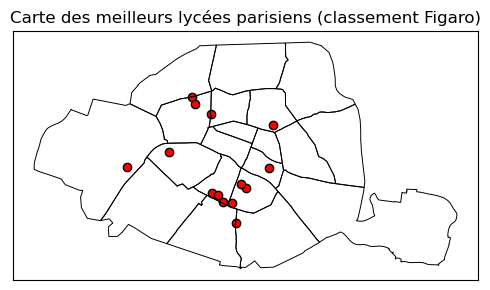

In [205]:
"""Visualisation des meilleurs lycées parisiens"""

fig, ax = plt.subplots(figsize=(6, 5))
paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7) #on ajout les arrondissements parisiens en rouge
df_meilleurs_lycées_paris.plot(ax=ax, color='red', alpha=1, edgecolor='black', linewidth=1) #on ajoute les lycées
#rien sur les axes
plt.xticks([], [])
plt.yticks([], [])
#titre
plt.title('Carte des meilleurs lycées parisiens (classement Figaro)')
plt.savefig('3.0) Enrichissement données/Sorties_cartes/carte_meilleurs_lycées_paris.png')
plt.show()

Maintenant, on calcule la distance minimale en appliquant une fonction similaire à celle utilisée jusqu'à présent.

In [143]:
"""Ajout des lycées au fichier dvf"""

from Enrichissement import ajout_meilleurs_lycées

dvf_avec_lycées = ajout_meilleurs_lycées(dvf_avec_trans, df_meilleurs_lycées_paris)

In [144]:
dvf_avec_lycées.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,geometry,nom_grand_parc,dist_min_grand_parc,nom_square,dist_min_square,nom_stat,num_ligne,dist_min_stat,nom_lycee,dist_min_lycee
60225,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,POINT (2.32098 48.87695),PARC MONCEAU,0.715347,SQUARE DES BATIGNOLLES,1.228584,Europe,3,0.224501,FÉNELON-SAINTE-MARIE-LA-PLAINE-MONCEAU,0.286341
60226,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,POINT (2.36714 48.85615),JARDIN DES PLANTES,1.146792,SQUARE LOUIS XIII,0.131711,Chemin Vert,8,0.132209,CHARLEMAGNE,0.536373


### **4) Ajout des des sites historiques**

On suit la même procédure que pour les lycées, mais cette fois pour ajouter les lieux historiques/touristiques. Comme le fichier initial contient un grand nombre de monuments, on va essayer de ne sélectionner que les plus emblématiques. La procédure est identique à celle utilisée pour les lycées. On récupère par scrapping les 50 monuments mentionnés sur un site touristique quelconque : https://parisjetaime.com/article/les-monuments-parisiens-un-patrimoine-exceptionnel-a024. Comme pour les lycées, la liste obtenue a été enregistrée dans le dossier `Projet-python-2A/3.0) Enrichissement données/Données` au cas où la structure du site changerait.

*Source des données des sites historiques : https://data.opendatasoft.com/explore/dataset/monuments-historiques-classes-ou-inscrits-en-ile-de-france-donnees-drac%40datailedefrance/export/?basemap=jawg.dark&location=14,48.84294,2.35215*

In [145]:
"""Lecture du fichier des sites historiques"""
emplacement = '3.0) Enrichissement données/Données/Monuments_historiques_idf.geojson'
df_monuments = gpd.read_file(emplacement, low_memory=False, index_col=0)

Pour les sites historiques (monuments), renseignés ici sous la forme de polygones, nous allons les réduire à des points pour réduire le temps de calcul. Il s'agit aussi de ne conserver que ceux de Paris intra-muros

In [223]:
"""Nettoyage"""

#restriction à Paris
df_monuments_paris = df_monuments.loc[df_monuments['dep']=='Paris']

#edifices publics et petits monuments
df_monuments_retenus = df_monuments_paris.loc[df_monuments_paris['type_archi'].isin(
    ['Edifice public', 'Petit monument', 'Edifice religieux'])
    ]

#Réduction à des points
proj_lambert = 'EPSG:3942'
df_monuments_retenus = df_monuments_retenus.to_crs(proj_lambert)
df_monuments_retenus['geometry'] = df_monuments_retenus['geometry'].centroid
proj_wgs84 = 'EPSG:4326'
df_monuments_retenus = df_monuments_retenus.to_crs(proj_wgs84)

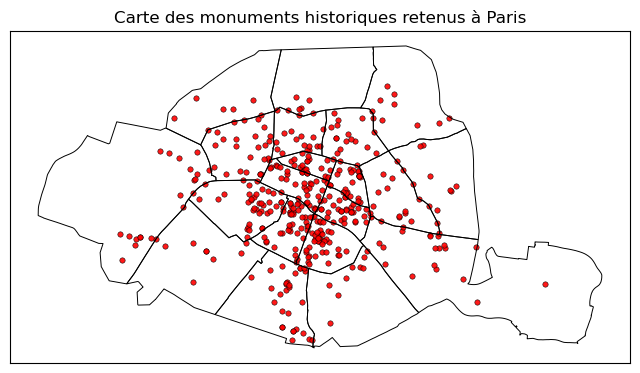

In [193]:
"""Première visualisation"""

fig, ax = plt.subplots(figsize=(8, 6))
base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
df_monuments_retenus.plot(ax=ax, color='red', alpha=0.9, markersize=15, edgecolor='black', linewidth=0.4)
plt.xticks([], [])
plt.yticks([], [])
plt.title('Carte des monuments historiques retenus à Paris')
plt.savefig('3.0) Enrichissement données/Sorties_cartes/carte_monuments_paris.png')
plt.show()

In [206]:
"""Scrapping pour récupérer la liste des monuments emblématiques"""

url = "https://parisjetaime.com/article/les-monuments-parisiens-un-patrimoine-exceptionnel-a024"

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
response = requests.get(url, headers=headers)

monuments_list = []

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')

    # Modifier le sélecteur CSS en fonction de la structure HTML du site
    monuments = soup.select('.layout_highlight_address_info')

    for monument in monuments:
        nom_du_monument = monument.text.strip()
        monuments_list.append(nom_du_monument)
else:
    print(f"Erreur {response.status_code} lors de la récupération de la page.")

#modification des la liste
monuments_list = [unidecode(monument.replace('-', '').replace(' ', '').upper()) for monument in monuments_list]

print(monuments_list)

['LATOUREIFFEL', 'MUSEEDULOUVRE', 'SAINTECHAPELLE', "MUSEED'ORSAY", 'FONDATIONLOUISVUITTON', 'PANTHEON', 'ARCDETRIOMPHE', 'MUSEEDUQUAIBRANLYJACQUESCHIRAC', 'INSTITUTDUMONDEARABE', 'MUSEERODINPARIS', 'CONCIERGERIE', 'CENTREPOMPIDOU', 'GRANDPALAIS', 'GRANDPALAISEPHEMERE', 'PETITPALAISMUSEEDESBEAUXARTSDELAVILLEDEPARIS', 'MUSEEDECLUNY-MUSEENATIONALDUMOYENAGE', 'CATHEDRALENOTREDAMEDEPARISETSONTRESOR', 'HOTELDEBETHUNESULLY', 'BASILIQUEDUSACRECOEURDEMONTMARTRE', 'AVENUEDESCHAMPSELYSEES', 'TOURSAINTJACQUES', 'HOTELDEVILLEDEPARIS', 'ILEDELACITE', 'GAREDUNORD', "GAREDEL'EST", "CIRQUED'HIVERBOUGLIONE", 'CATHEDRALEDELASAINTETRINITEEGLISEORTHODOXERUSSE', 'CENTREBOUDDHIQUEKAGYUDZONGGRANDEPAGODEDEVINCENNES', 'PLACEDELACONCORDE', 'TOURJEANSANSPEUR', 'ARENESDELUTECEETSQUARECAPITAN', 'PALAISDETOKYO', 'PASSAGEBRADY', 'OPERANATIONALDEPARISPALAISGARNIER', 'CIMETIEREDUPERELACHAISE', 'PARISMONTPARNASSETOPOFTHECITY']


In [227]:
"""Chargement de la liste en cas d'échec du scrapping"""
with open('3.0) Enrichissement données/Données/liste_principaux_monuments.pkl', 'rb') as file:
    monuments_list = pickle.load(file)

In [224]:
"""Restriction des données aux monuments principaux"""

#modifier la colonne contenant les noms
df_monuments_retenus['nom_modif'] = df_monuments_retenus['immeuble'].apply(lambda x: unidecode(x.replace(' ', '').replace('-', '').replace('Métropolitain', '')
                                                                                            .replace('station', '').replace(',','').upper()))

# Appliquer la fonction pour créer une colonne de vérification de similarité
df_monuments_retenus['similar_name'] = df_monuments_retenus['nom_modif'].apply(lambda x: has_similar_name(x, monuments_list,56))

# Filtrer les données en fonction de la colonne de similarité
df_monuments_principaux = df_monuments_retenus[df_monuments_retenus['similar_name'] | df_monuments_retenus['nom_modif'].isin(monuments_list)]

# Supprimer la colonne temporaire 'similar_name'
df_monuments_principaux = df_monuments_principaux.drop(columns=['similar_name'])

"""Vérification du nombre de monumnets retenus"""
df_monuments_principaux.shape

(50, 22)

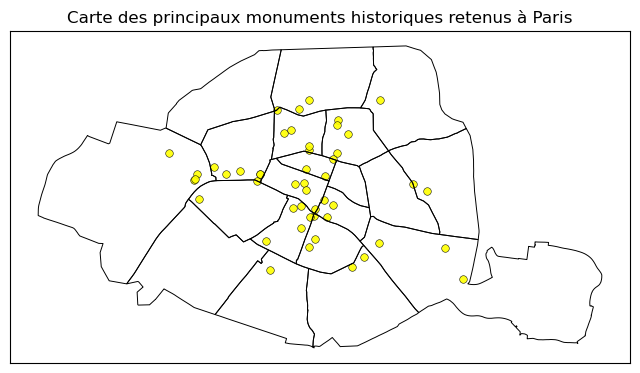

In [225]:
"""Deuxième visualisation"""

fig, ax = plt.subplots(figsize=(8, 6))
base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
df_monuments_principaux.plot(ax=ax, color='yellow', alpha=0.9, markersize=30, edgecolor='black', linewidth=0.4)
plt.xticks([], [])
plt.yticks([], [])
plt.title('Carte des principaux monuments historiques retenus à Paris')
plt.savefig('3.0) Enrichissement données/Sorties_cartes/carte_monuments_paris.png')
plt.show()

In [202]:
"""Ajout au fichier dvf"""

from Enrichissement import ajout_sites_histo

dvf_avec_sites_histo = ajout_sites_histo(dvf_avec_lycées, df_monuments_principaux)

dvf_avec_sites_histo.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,dist_min_grand_parc,nom_square,dist_min_square,nom_stat,num_ligne,dist_min_stat,nom_lycee,dist_min_lycee,nom_site_histo,dist_min_site_histo
60225,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,0.715347,SQUARE DES BATIGNOLLES,1.228584,Europe,3,0.224501,FÉNELON-SAINTE-MARIE-LA-PLAINE-MONCEAU,0.286341,Eglise de la Trinité,0.770349
60226,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,1.146792,SQUARE LOUIS XIII,0.131711,Chemin Vert,8,0.132209,CHARLEMAGNE,0.536373,Hôtel de Ville,1.078004


### **5) Ajout des des voies d'eau**

On enrichit encore nos données, en ajoutant la distance au voies d'eau (Seine et canal Saint-Martin), pour essayer de capter l'effet "vue sur la Seine" dans le prix de l'immobilier.

*Source des données : https://opendata.paris.fr/explore/dataset/plan-de-voirie-voies-deau/export/?disjunctive.num_pave&disjunctive.lib_level&disjunctive.lib_classe*

In [216]:
"""Lecture du fichier des voies d'eau"""
emplacement = '3.0) Enrichissement données/Données/Voies_eau_paris.geojson'
df_eau = gpd.read_file(emplacement, low_memory=False, index_col=0)

"""Rassemblement des voies d'eau en un seul polygone"""
union_polygon = df_eau.unary_union
# Créer un nouveau DataFrame GeoPandas avec le polygone résultant
df_eau = gpd.GeoDataFrame(geometry=[union_polygon], crs=df_eau.crs)

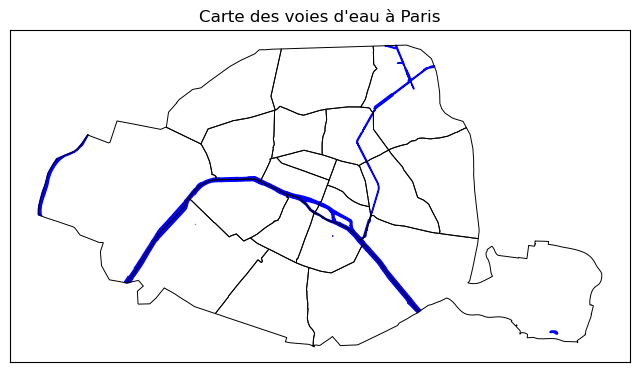

In [217]:
"""Visualisation des voies d'eau sur une carte"""

fig, ax = plt.subplots(figsize=(8, 6))
base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
df_eau.plot(ax=ax, color='blue', alpha=1, edgecolor='blue', linewidth=1)
plt.xticks([], [])
plt.yticks([], [])
plt.title("Carte des voies d'eau à Paris")
plt.savefig('3.0) Enrichissement données/Sorties_cartes/carte_voies_eau.png')
plt.show()

In [242]:
"""Ajout au fichier dvf"""

from Enrichissement import ajout_voies_eau

dvf_avec_eau = ajout_voies_eau(dvf_avec_sites_histo, df_eau)

dvf_avec_eau.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,nom_square,dist_min_square,nom_stat,num_ligne,dist_min_stat,nom_lycee,dist_min_lycee,nom_site_histo,dist_min_site_histo,dist_min_voie_eau
60225,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,SQUARE DES BATIGNOLLES,1.228584,Europe,3,0.224501,FÉNELON-SAINTE-MARIE-LA-PLAINE-MONCEAU,0.286341,Eglise de la Trinité,0.770349,1.418265
60226,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,SQUARE LOUIS XIII,0.131711,Chemin Vert,8,0.132209,CHARLEMAGNE,0.536373,Hôtel de Ville,1.078004,0.229360


### **6) Ajout de la distance au centre**

On finalise l'enrichissement de nos données, en ajoutant la distance au centre de Paris (représenté par un point arbitraire situé au nord de l'Île de la Cité). En effet, la ville de Paris (c'est à dire tous les lieux d'intérêts ajoutés jusque-là) est très centralisée : il y a moins de sites historiques par exemple en bordure de Paris, ce qui se reflète dans le prix des quartiers observé plus haut. L'ajout d'une variable `dist_min_centre_paris` pourra donc servir de bonne variable de contrôle.

In [229]:
centre_paris = [2.343678767984111, 48.85602158061093] 

In [235]:
centre_paris_point = Point(centre_paris)
centre_paris_gdf = gpd.GeoDataFrame(geometry=[centre_paris_point], crs='EPSG:4326')

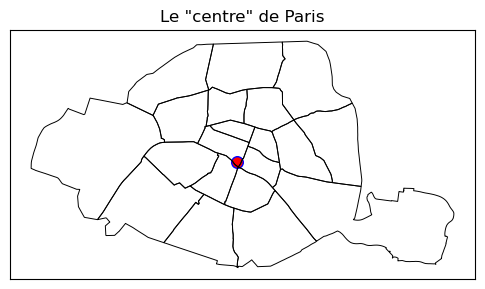

In [240]:
"""Visualisation du centre sur une carte"""

fig, ax = plt.subplots(figsize=(6, 4))
base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
centre_paris_gdf.plot(ax=ax, color='red', alpha=1, edgecolor='blue', markersize=70, linewidth=1)
plt.xticks([], [])
plt.yticks([], [])
plt.title('Le "centre" de Paris')
plt.show()

In [246]:
"""Ajout au fichier dvf"""

from Enrichissement import ajout_centre_paris

dvf_avec_dist_centre = ajout_centre_paris(dvf_avec_eau, centre_paris_gdf)

dvf_avec_dist_centre.head(2)

,id_mutation,date_mutation,prix,log_prix,nombre_pieces_principales,surface_reelle_bati,surface_carrez,nombre_dependances,prix_au_m2_carrez,prix_au_m2_reel_bati,...,dist_min_square,nom_stat,num_ligne,dist_min_stat,nom_lycee,dist_min_lycee,nom_site_histo,dist_min_site_histo,dist_min_voie_eau,dist_min_paris_centre
60225,2021-1680087,2021-01-05,1480000.0,14.207553,5.0,111.0,116.01,3.0,12758.0,13333.0,...,1.228584,Europe,3,0.224501,FÉNELON-SAINTE-MARIE-LA-PLAINE-MONCEAU,0.286341,Eglise de la Trinité,0.770349,1.418265,2.883285
60226,2021-1680092,2021-01-07,300000.0,12.611538,1.0,23.0,19.39,0.0,15472.0,13043.0,...,0.131711,Chemin Vert,8,0.132209,CHARLEMAGNE,0.536373,Hôtel de Ville,1.078004,0.229360,1.734097


## **IV) Modélisation**

Dans cette partie, le but sera de prédire au mieux le prix de l'immobilier, d'abord dans une approche plus "économétrique" (régression simple, utilisant l'effet fixe des quartiers), puis dans une approche plus "machine learning" (régression LASSO, RIDGE et RandomForest).

### **1) Observation des variables, préprocessing**

Ici, on va d'abord observer la distribution des distances qui ont été ajoutées au dataframe, puis on étudiera les choix de discrétisation pour envisager un effet non linéaire de certaines variables, et on observera les corrélations.

In [346]:
dvf_enrichi = dvf_avec_dist_centre.copy()

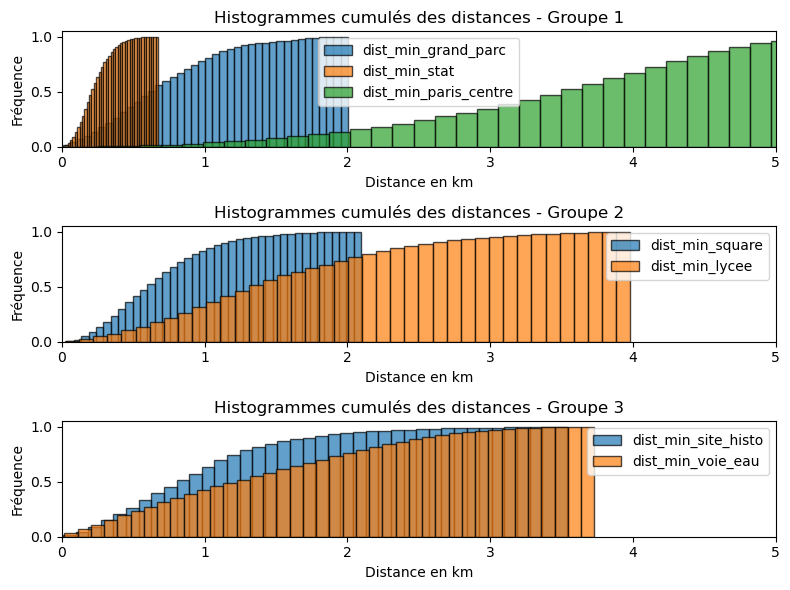

In [264]:
"""Distribution des distances"""

liste_var_dist = ['dist_min_grand_parc', 'dist_min_square', 'dist_min_site_histo', 
                  'dist_min_stat', 'dist_min_lycee', 'dist_min_voie_eau', 'dist_min_paris_centre']

# Initialiser une plage commune pour l'axe x
x_range = (0, 5)  # Ajustez selon vos besoins

# Créer une figure avec 3 sous-plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

# Boucle pour créer les histogrammes
for i, variable in enumerate(liste_var_dist):
    row = i % 3

    # Créer un histogramme de l'effectif cumulé
    axes[row].hist(dvf_enrichi[variable], bins=40, edgecolor='black', alpha=0.7, density=True, cumulative=True, label=variable)

    # Ajouter des étiquettes et un titre
    axes[row].set_xlabel('Distance en km')
    axes[row].set_ylabel('Fréquence')
    axes[row].set_title(f'Histogrammes cumulés des distances - Groupe {row + 1}')
    axes[row].set_xlim(x_range)
    axes[row].legend()

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()

# Afficher les histogrammes
plt.show()

On peut voir que tous les appartements parisiens sont à moins de 800m environ d'une station de métro, et à moins de deux kilomètres d'un grand espace vert.
  

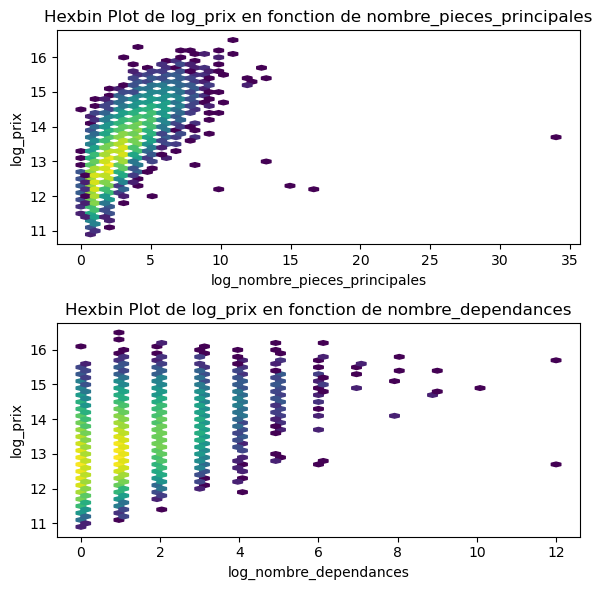

In [347]:
# Liste des variables explicatives
variables_explicatives = ['nombre_pieces_principales', 'nombre_dependances']

# Créer des sous-plots pour chaque variable explicative
fig, axes = plt.subplots(nrows=len(variables_explicatives), ncols=1, figsize=(6, 3 * len(variables_explicatives)))

# Boucle pour créer les graphiques hexbin
for i, variable_explicative in enumerate(variables_explicatives):
    axes[i].hexbin(dvf_enrichi[variable_explicative], dvf_enrichi['log_prix'], gridsize=50, cmap='viridis', bins='log')
    axes[i].set_xlabel(f'log_{variable_explicative}')
    axes[i].set_ylabel('log_prix')
    axes[i].set_title(f'Hexbin Plot de log_prix en fonction de {variable_explicative}')

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()

# Afficher les graphiques hexbin
plt.show()

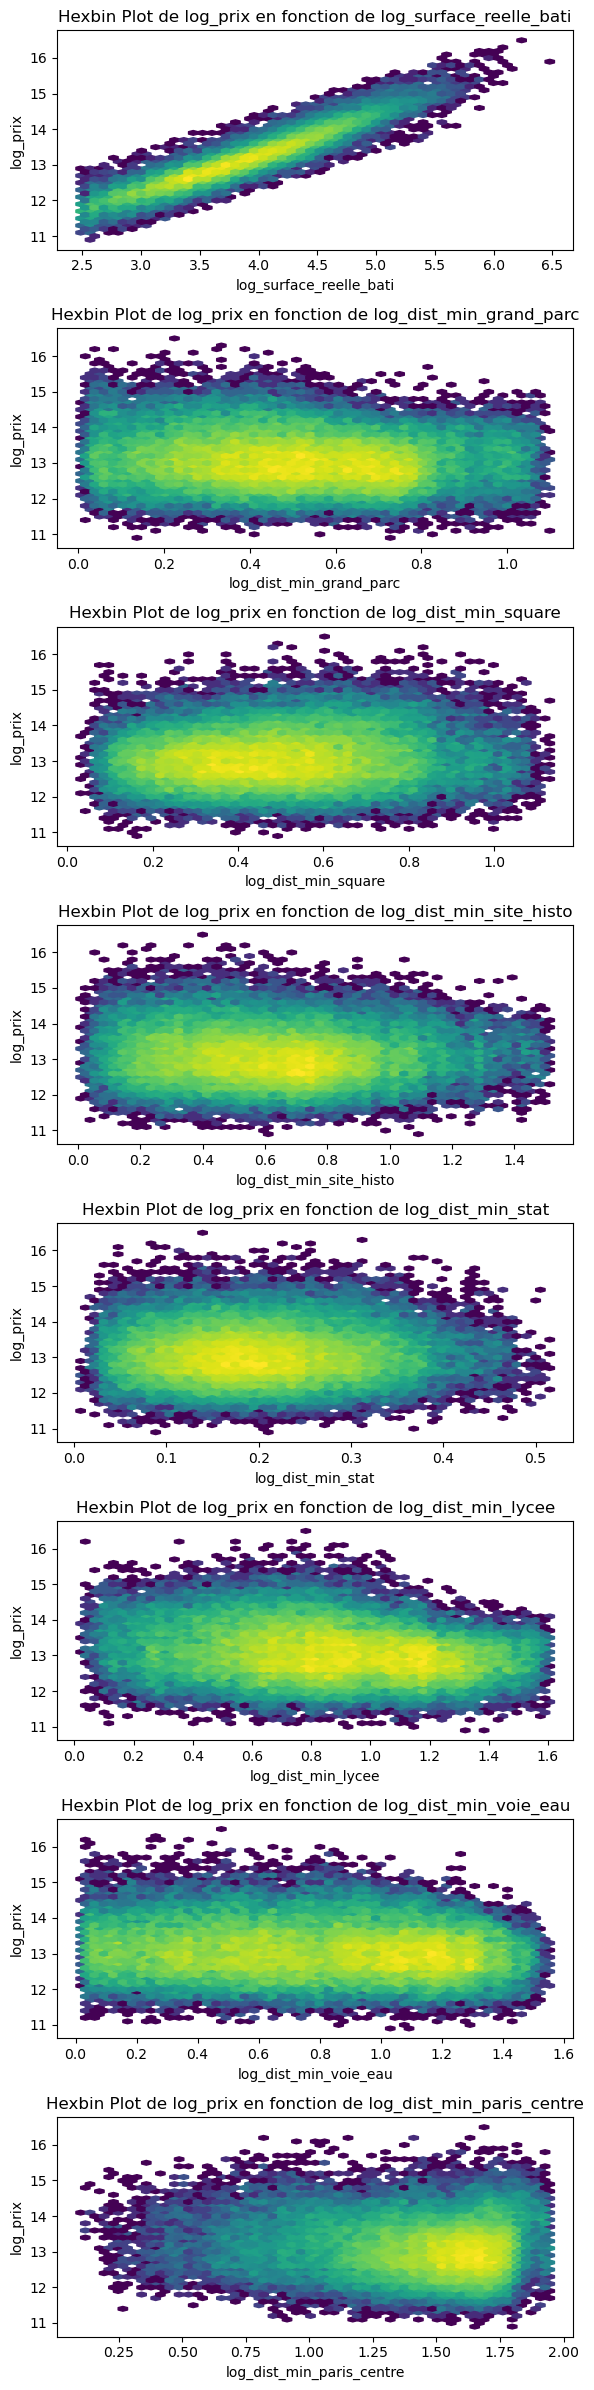

In [348]:
# Liste des variables explicatives
variables_explicatives = ['surface_reelle_bati', 'dist_min_grand_parc', 'dist_min_square', 'dist_min_site_histo', 
                           'dist_min_stat', 'dist_min_lycee', 'dist_min_voie_eau', 'dist_min_paris_centre']

# Appliquer le logarithme aux variables explicatives
for variable_explicative in variables_explicatives:
    dvf_enrichi[f'log_{variable_explicative}'] = np.log1p(dvf_enrichi[variable_explicative])

# Créer des sous-plots pour chaque variable explicative
fig, axes = plt.subplots(nrows=len(variables_explicatives), ncols=1, figsize=(6, 3 * len(variables_explicatives)))

# Boucle pour créer les graphiques hexbin
for i, variable_explicative in enumerate(variables_explicatives):
    axes[i].hexbin(dvf_enrichi[f'log_{variable_explicative}'], dvf_enrichi['log_prix'], gridsize=50, cmap='viridis', bins='log')
    axes[i].set_xlabel(f'log_{variable_explicative}')
    axes[i].set_ylabel('log_prix')
    axes[i].set_title(f'Hexbin Plot de log_prix en fonction de log_{variable_explicative}')

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()

# Afficher les graphiques hexbin
plt.show()

On peut donc avoir une bonne confiance dans l'effet linéaire des trois premières variables (surface, nombre de pièces, nombre de dépendances), avec un effet non linéaire comme on pouvait s'en douter. Pour toutes nos variables de distance, c'est plus difficile à dire pour l'instant.

In [317]:
def plot_prix_moyen_par_interval(dvf_enrichi, variable_distance, bornes, labels):
    """
    Plot the average price for different intervals of a given distance variable.

    Parameters:
    - dvf_enrichi: DataFrame with the enriched data
    - variable_distance: Name of the distance variable
    - bornes: List of interval edges
    - labels: Labels for the intervals
    Returns:
    - None (plots the histogram)
    """
    # Définir la taille de la figure
    plt.figure(figsize=(6,4))

    # Ajouter une colonne 'variable_distance_interval' pour représenter les intervalles
    dvf_enrichi[f'{variable_distance}_interval'] = pd.cut(dvf_enrichi[variable_distance], bins=bornes, labels=labels)

    # Convertir la colonne en catégorie pour inclure les étiquettes manquantes
    dvf_enrichi[f'{variable_distance}_interval'] = pd.Categorical(dvf_enrichi[f'{variable_distance}_interval'], categories=labels, ordered=True)

    # Calculer le prix moyen global
    prix_moyen_global = dvf_enrichi['prix'].mean()

    # Calculer le prix moyen pour chaque intervalle
    prix_moyen_par_interval = dvf_enrichi.groupby(f'{variable_distance}_interval', observed=False)['prix'].mean()

    # Créer un histogramme avec une largeur de barre ajustée
    plt.bar(prix_moyen_par_interval.index, prix_moyen_par_interval, width=0.6, label='Prix moyen par intervalle')

    # Ajouter une barre pour le prix moyen global
    plt.axhline(y=prix_moyen_global, color='red', linestyle='--', label='Prix moyen global')

    # Ajouter des étiquettes et un titre
    plt.xlabel(f'Plage de {variable_distance}')
    plt.ylabel('Prix moyen')
    plt.title(f'Prix moyen en fonction de {variable_distance}')
    plt.legend(loc='lower right')  # Ajouter la légende

    # Afficher l'histogramme
    plt.show()

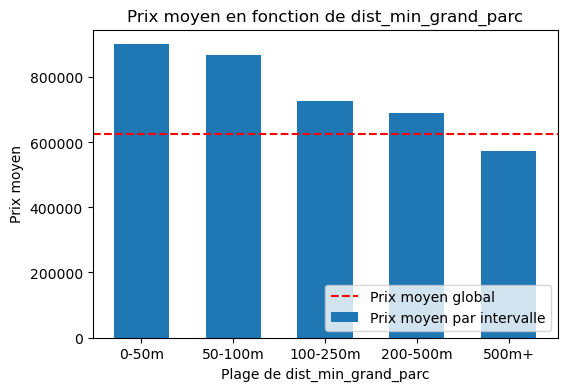

In [318]:
bornes_parc = [0.0, 0.05, 0.1, 0.25, 0.5, 10]
labels_parc = ['0-50m', '50-100m', '100-250m', '200-500m', '500m+']
plot_prix_moyen_par_interval(dvf_enrichi, 'dist_min_grand_parc', bornes_parc, labels_parc)

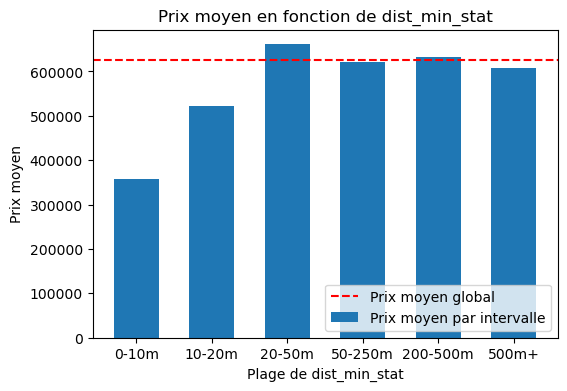

In [320]:
bornes_stat = [0.0, 0.01, 0.02, 0.05, 0.25, 0.5, 10]
labels_stat = ['0-10m', '10-20m', '20-50m', '50-250m', '200-500m', '500m+']
plot_prix_moyen_par_interval(dvf_enrichi, 'dist_min_stat', bornes_stat, labels_stat)

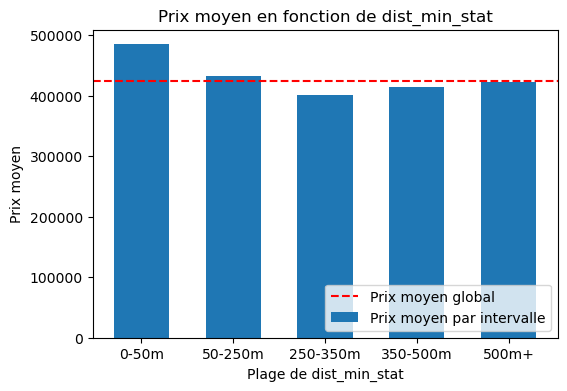

In [339]:
dvf_enrichi_20eme = dvf_enrichi.loc[dvf_enrichi['num_arrondissement']=='20'].copy()
bornes_stat = [0.0, 0.05, 0.25, 0.35, 0.5, 10]
labels_stat = ['0-50m', '50-250m', '250-350m', '350-500m', '500m+']
plot_prix_moyen_par_interval(dvf_enrichi_20eme, 'dist_min_stat', bornes_stat, labels_stat)

### **2) Approche économétrique : régression simple et de panel**

### **3) Approche orientée prédiction : régression LASSO, RIDGE, algorithme Randomforest**